Prepare for the dataset

In [1]:
import pandas as pd
import numpy as np
import random

np.random.seed(42)

n_rows = 1000
n_pre_law = 500
n_post_law = 500

crime_rates_pre_law = np.random.poisson(lam=100, size = n_pre_law)
crime_rates_post_law = np.concatenate([np.random.poisson(lam=100, size=n_post_law//2) * np.random.uniform(0.8, 1.2),
                                      np.random.poisson(lam=100, size=n_post_law//2) * np.random.uniform(0.6, 0.8)])

data_pre_law = pd.DataFrame({
    'crime_rate': crime_rates_pre_law,
    'treated_location': [0] * (n_pre_law//2) + [1] * (n_pre_law//2),
    'post_law': 0
})

data_post_law = pd.DataFrame({
    'crime_rate': crime_rates_post_law,
    'treated_location': [0] * (n_post_law//2) + [1] * (n_post_law//2),
    'post_law': 1
})

df = pd.concat([data_pre_law, data_post_law]).reset_index(drop=True)
df = df.sample(frac = 1).reset_index(drop=True)

df.head()
# df.to_csv('synthetic_crime_data.csv', index=False)

,crime_rate,treated_location,post_law
0,81.168142,0,1
1,98.000000,1,0
2,59.290610,1,1
3,87.000000,1,0
4,56.794163,1,1


Calculate the Pre- and Post-Law Mean Crime Rates for the Treated Location

In [5]:
law_before = df.query("treated_location==1 & post_law==0")["crime_rate"].mean()
law_after = df.query("treated_location==1 & post_law==1")["crime_rate"].mean()

law_after - law_before

-36.87969664778486

On average, the crime rate in the treated location (where the law was posted) decreased by approximately 36.88 units after the introduction of the law compared to before.

Calculate the Pre- and Post-Law Mean Crime Rates for the Control Location

In [7]:
location_after = df.query("treated_location==0 & post_law==1")["crime_rate"].mean()
law_after - location_after

-27.700970298849064

After the law was introduced, the crime rate in the treated location was approximately 27.70 units lower than the crime rate in the control location during the same period.

Difference-in-Differences Calculation

In [8]:
location_before = df.query("treated_location==0 & post_law==0")["crime_rate"].mean()

diff_in_diff = (law_after-law_before)-(location_after-location_before)
diff_in_diff

-27.224970298849065

Visualization

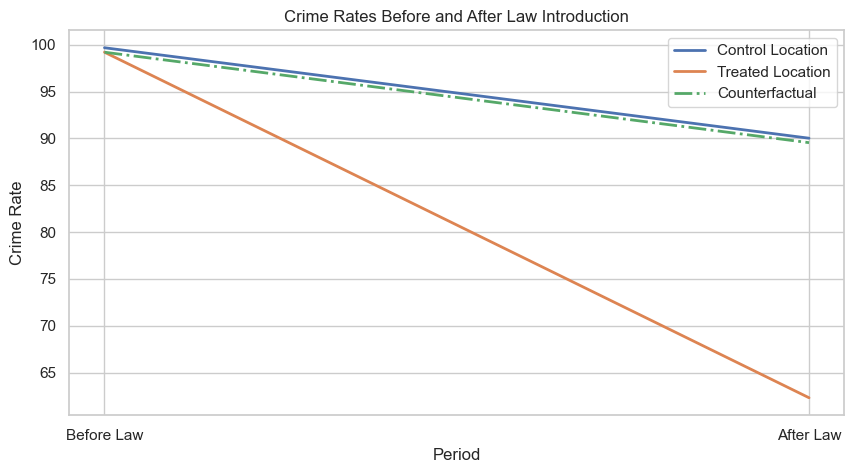

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,5))
plt.plot(["Before Law", "After Law"], [location_before, location_after], label="Control Location", lw=2)
plt.plot(["Before Law", "After Law"], [law_before, law_after], label="Treated Location", lw=2)

counterfactual_after = law_before + (location_after - location_before)

plt.plot(["Before Law", "After Law"], [law_before, counterfactual_after],
         label="Counterfactual", lw=2, color="C2", ls="-.")

plt.title("Crime Rates Before and After Law Introduction")
plt.xlabel("Period")
plt.ylabel("Crime Rate")
plt.legend()
plt.show()

In [14]:
import statsmodels.formula.api as smf
smf.ols('crime_rate ~ treated_location*post_law', data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,99.6720,0.592,168.385,0.000,98.510,100.834
treated_location,-0.4760,0.837,-0.569,0.570,-2.119,1.167
post_law,-9.6547,0.837,-11.533,0.000,-11.297,-8.012
treated_location:post_law,-27.2250,1.184,-22.997,0.000,-29.548,-24.902
